In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListChb
from lib.signals import EegProcessorChb
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.bss import IWasobi, EogDenoiser, CanonicalCorrelation, EmgDenoiser
from lib.stats import StatisticalTests
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

{"NULL": 198}
Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/chb-mit/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-03-17 20:19:44,760 - root - INFO - Recording contains channels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']


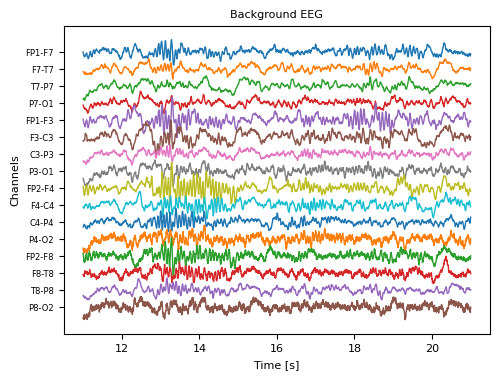

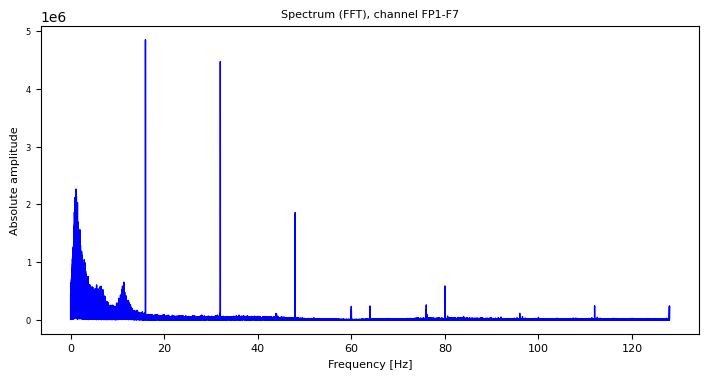

In [2]:
PATIENT = "chb01"
FILENAME = "chb01_03.edf"
PERIOD = [11, 21]

###########################################################
metadata = MetadataListChb()
metadata.summarize()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorChb(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1-F7")

### * Resample the EEG to 256Hz

2025-03-04 22:59:30,527 - root - INFO - Selected frequency is = 256
2025-03-04 22:59:30,532 - root - INFO - Dowsampling factor is = 1


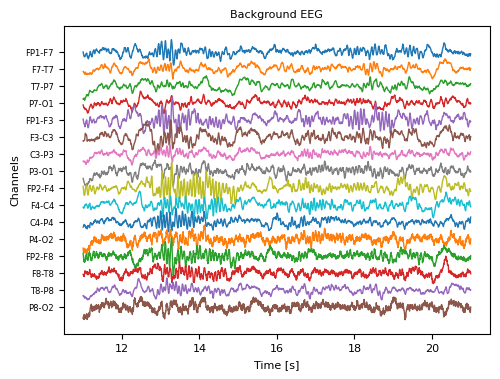

In [3]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Remove the drift noise, high frequency oscillations, power line noise

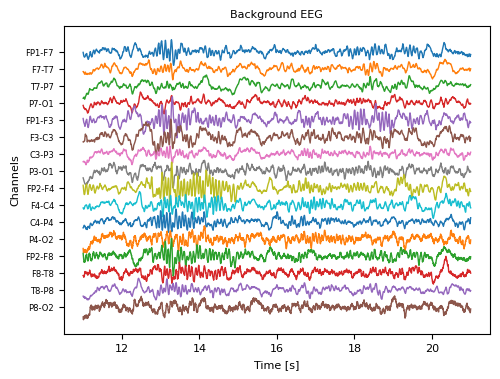

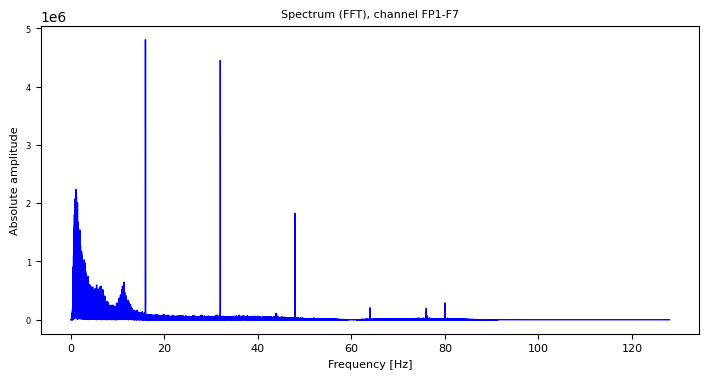

In [4]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1-F7")

### Compute sources by using iWASOBI

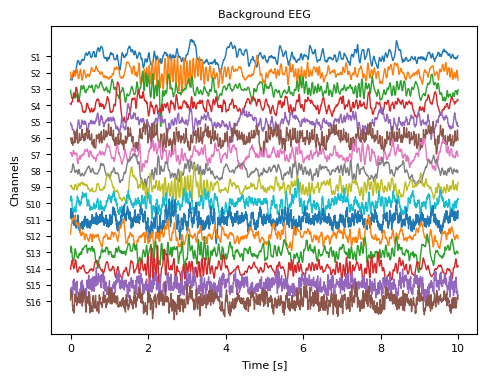

Source = 1, fd = 4.27760451299083
Source = 2, fd = 4.918450766702346
Source = 3, fd = 4.5926229044692315
Source = 4, fd = 4.474927205889458
Source = 5, fd = 4.716682610748226
Source = 6, fd = 5.372798189941193
Source = 7, fd = 4.6434281451283965
Source = 8, fd = 4.363296520721844
Source = 9, fd = 4.775516600963039
Source = 10, fd = 5.261595171736638
Source = 11, fd = 5.919513319302376
Source = 12, fd = 4.580855200111916
Source = 13, fd = 4.764832182954679
Source = 14, fd = 4.7620084595929555
Source = 15, fd = 5.935373644439026
Source = 16, fd = 5.823619402360292
Done!
2025-02-21 00:18:08,429 - root - INFO - Number of sources to be removed = 2


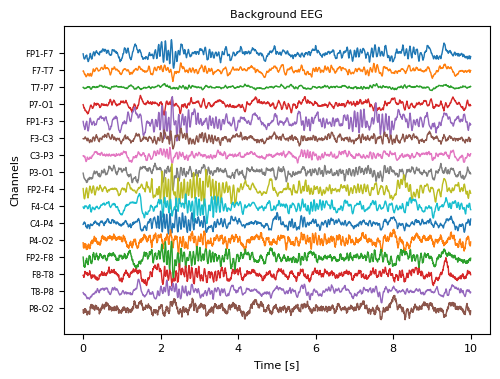

In [5]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                       PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eog_denoiser = EogDenoiser()
eog_denoiser.fit_fractal_dimensions(eeg_sources)
print(eog_denoiser)

eeg_sources = eog_denoiser.remove_low_dimension_sources([0, 2])

###########################################################
clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using fastica

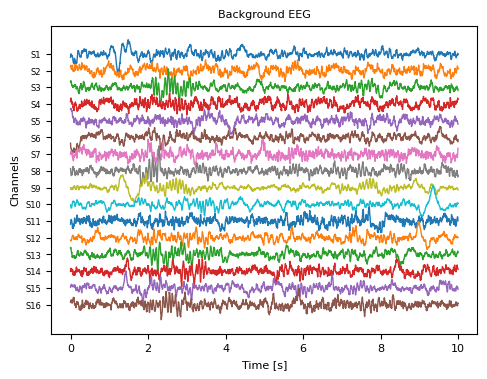

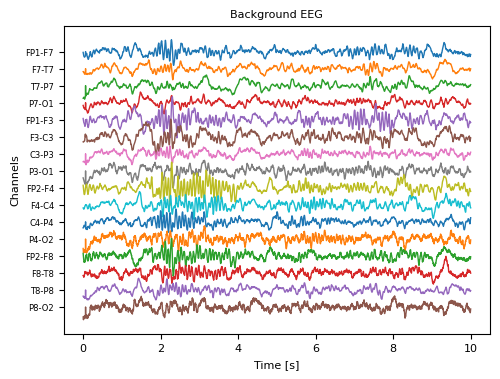

In [6]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

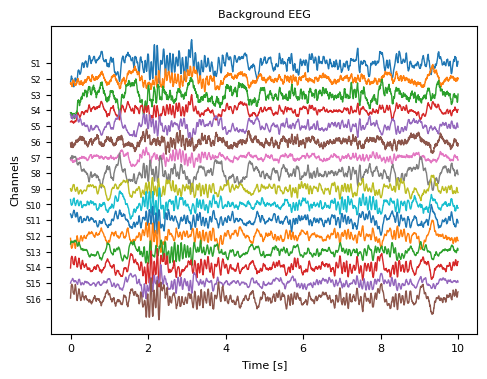

Source = 1, fd = 27.616407592059698
Source = 2, fd = 62.80820083715246
Source = 3, fd = 96.58553022393119
Source = 4, fd = 57.57822621984114
Source = 5, fd = 72.1149754971628
Source = 6, fd = 49.59824140534931
Source = 7, fd = 39.52718599491774
Source = 8, fd = 97.24698675337761
Source = 9, fd = 41.521158775227796
Source = 10, fd = 27.176758636622697
Source = 11, fd = 34.50350665244616
Source = 12, fd = 34.14845067951872
Source = 13, fd = 33.471197881221755
Source = 14, fd = 25.247285032292414
Source = 15, fd = 36.34979402495964
Source = 16, fd = 23.60193279859324
Done!
2025-02-21 00:18:18,618 - root - INFO - Number of sources to be removed = 0


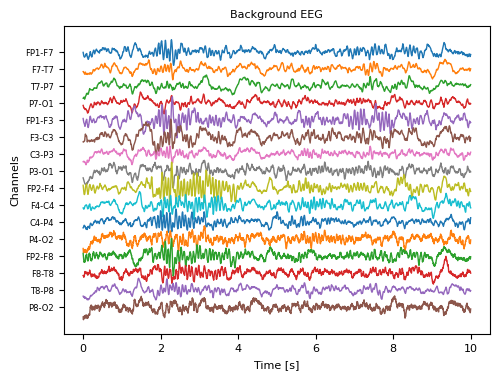

In [7]:
bsscca = CanonicalCorrelation()
eeg_sources = bsscca.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                      PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
emg_denoiser = EmgDenoiser(sampling_frequency=processor.sampling_frequency)
emg_denoiser.fit_psd_ratio(eeg_sources)
print(emg_denoiser)

eeg_sources = emg_denoiser.remove_low_ratio_sources([0, 5])

###########################################################
clean_eeg = bsscca.inverse_transform(eeg_sources)
plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Stationarity tests (KPPS and ADF)

In [10]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[15, :4000])

2025-02-21 00:21:38,786 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-02-21 00:21:39,151 - root - INFO - ADF test, null hyphotesis was rejected, p_value = 4.673586799853306e-13, significance level = 0.05
2025-02-21 00:21:39,152 - root - INFO - The time serie is stationary
